# Required Libraries

In [1]:
!pip install pandas numpy scipy matplotlib seaborn geopandas


[notice] A new release of pip is available: 24.0 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")

# Global Variables

In [3]:
data_dir = "data/"
plots_dir = "plots/"
grids_dir = data_dir + "grids/"
birds_filepath = data_dir + "birds_data.csv"
kenya_filepath = data_dir + "kenya_boundaries/geoBoundaries-KEN-ADM2.shp"

relevant_columns = ["species", "speciesKey", "decimalLatitude", "decimalLongitude", "day", "month", "year", "individualCount", "occurrenceStatus"]

# Data

In [4]:
data = pd.read_csv(birds_filepath, delimiter="\t")[relevant_columns]
data = data[data["occurrenceStatus"] == "PRESENT"]
data.drop(labels=["occurrenceStatus"], axis=1, inplace=True)

In [5]:
data

,species,speciesKey,decimalLatitude,decimalLongitude,day,month,year,individualCount
0,Zosterops silvanus,6100772.0,-3.432285,38.341012,9,11,2017,1.0
1,Zosterops senegalensis,2489344.0,0.206000,34.884667,1,6,2017,1.0
2,Zosterops senegalensis,2489344.0,-0.558500,36.523667,1,6,2017,4.0
3,Zosterops silvanus,6100772.0,-3.399601,38.329516,6,10,2017,1.0
4,Zosterops silvanus,6100772.0,-3.380438,38.353286,6,10,2017,1.0
...,...,...,...,...,...,...,...,...
89627,Accipiter badius,2480610.0,1.114823,37.460524,13,1,2018,1.0
89628,Accipiter badius,2480610.0,1.010063,37.385208,12,1,2018,1.0
89629,Accipiter melanoleucus,2480631.0,-3.991421,39.692136,29,1,2018,1.0
89630,Accipiter badius,2480610.0,-3.415807,38.650147,1,2,2018,1.0


# Kenya Map

In [6]:
# load the shapefile of Kenya
kenya = gpd.read_file(kenya_filepath)
# convert the pandas DataFrame to a GeoDataFrame
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))
# set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdata.set_crs(epsg=4326, inplace=True)

,species,speciesKey,decimalLatitude,decimalLongitude,day,month,year,individualCount,geometry
0,Zosterops silvanus,6100772.0,-3.432285,38.341012,9,11,2017,1.0,POINT (38.34101 -3.43228)
1,Zosterops senegalensis,2489344.0,0.206000,34.884667,1,6,2017,1.0,POINT (34.88467 0.206)
2,Zosterops senegalensis,2489344.0,-0.558500,36.523667,1,6,2017,4.0,POINT (36.52367 -0.5585)
3,Zosterops silvanus,6100772.0,-3.399601,38.329516,6,10,2017,1.0,POINT (38.32952 -3.3996)
4,Zosterops silvanus,6100772.0,-3.380438,38.353286,6,10,2017,1.0,POINT (38.35329 -3.38044)
...,...,...,...,...,...,...,...,...,...
89627,Accipiter badius,2480610.0,1.114823,37.460524,13,1,2018,1.0,POINT (37.46052 1.11482)
89628,Accipiter badius,2480610.0,1.010063,37.385208,12,1,2018,1.0,POINT (37.38521 1.01006)
89629,Accipiter melanoleucus,2480631.0,-3.991421,39.692136,29,1,2018,1.0,POINT (39.69214 -3.99142)
89630,Accipiter badius,2480610.0,-3.415807,38.650147,1,2,2018,1.0,POINT (38.65015 -3.41581)


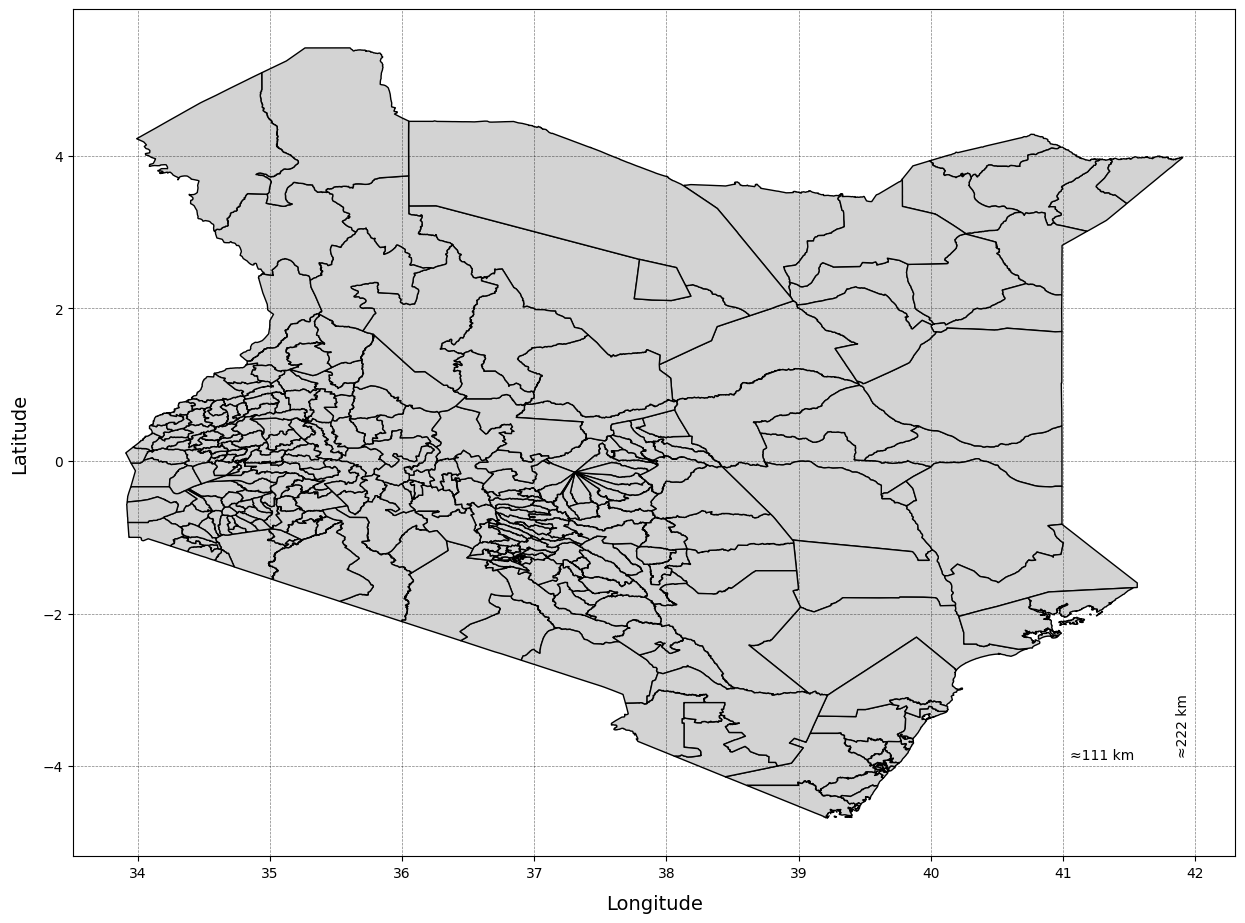

In [7]:
fig, ax = plt.subplots(figsize=(15, 11))
kenya.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=1)
ax.set_aspect("auto")
ax.grid(color="black", linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_xlabel("Longitude", fontsize=14, labelpad=10)
ax.set_ylabel("Latitude", fontsize=14, labelpad=10)

scalebar_text_x = "≈111 km"
scalebar_text_y = "≈222 km"
ax.text(
    0.885, 0.115, scalebar_text_x, 
    transform=ax.transAxes, ha="center", 
    fontsize=10, color="black"
)
ax.text(
    0.955, 0.12, scalebar_text_y, 
    transform=ax.transAxes, ha="center", rotation=90,
    fontsize=10, color="black"
)

fig.savefig(plots_dir + "kenya.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# 2. Clusters of Bird Sightings

In order to answer to this question we will use DBSCAN, an unsupervised Machine Learning Algorithm for clustering. After creating the clusters using DBSCAN we will plot those in different colors using GeoPandas and Matplotlib.

### Prepare Data for Clustering

Before running DBSCAN on our data we need to load and prepare our location data by removing null values and converting into numeric types that can be interpreted by the model

In [8]:
birds_data = pd.read_csv(birds_filepath, delimiter='\t')

location_data = birds_data[['decimalLatitude', 'decimalLongitude']].dropna()
location_data['decimalLatitude'] = pd.to_numeric(location_data['decimalLatitude'], errors='coerce')
location_data['decimalLongitude'] = pd.to_numeric(location_data['decimalLongitude'], errors='coerce')
location_data = location_data.dropna()

coords = location_data[['decimalLatitude', 'decimalLongitude']].values

### Determine Optimal DBSCAN Hyperparameter

Since DBSCAN relies on a hyperparameter epsilon `eps` for clustering, the last step before running the algorithm is to determine an optimal value for this parameter. This can be done by using the **K-distance Plot** method.
The method consists of calculating for each point the distance to its k-th nearest neighbour (k being the minimum number of samples for a cluster) then sort and plot these distances and find an elbow (like in the elbow method for KMeans) where the distance sharply increases. That is the ideal value for `eps`.

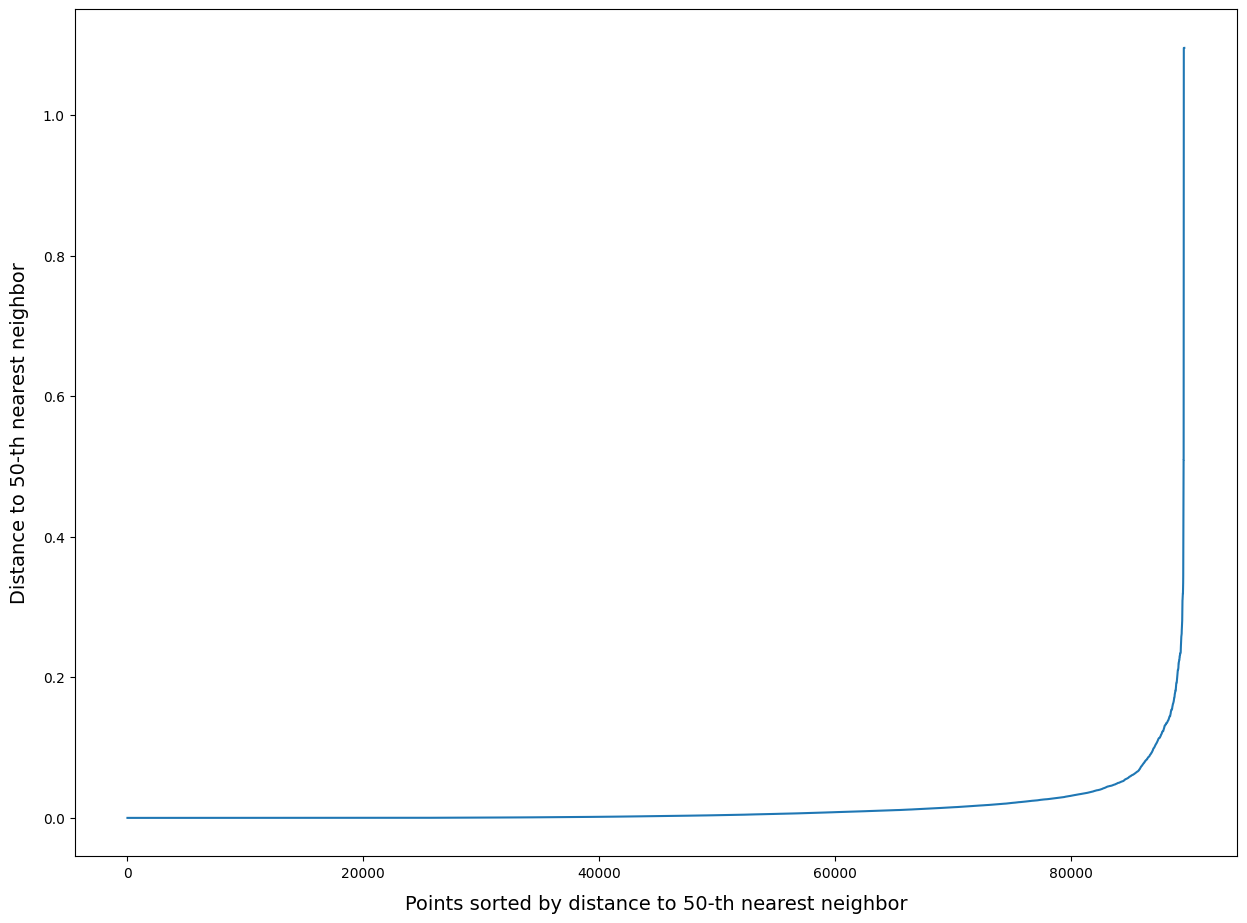

In [9]:
# we set 50 to be the minimum number of birds to consider it a cluster
min_samples = 50  

# calculate the distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(coords)
distances, indices = neighbors_fit.kneighbors(coords)

# sort and plot
distances = np.sort(distances[:, -1])
fig, ax = plt.subplots(figsize=(15, 11))
ax.plot(distances)
ax.set_xlabel("Points sorted by distance to {}-th nearest neighbor".format(min_samples), fontsize=14, labelpad=10)
ax.set_ylabel("Distance to {}-th nearest neighbor".format(min_samples), fontsize=14, labelpad=10)
fig.savefig(plots_dir + "k-distance-plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

**Observation** we see that the sharp increase happens around a value of 0.1 so we use that as our epsillon.

### Clustering Plot

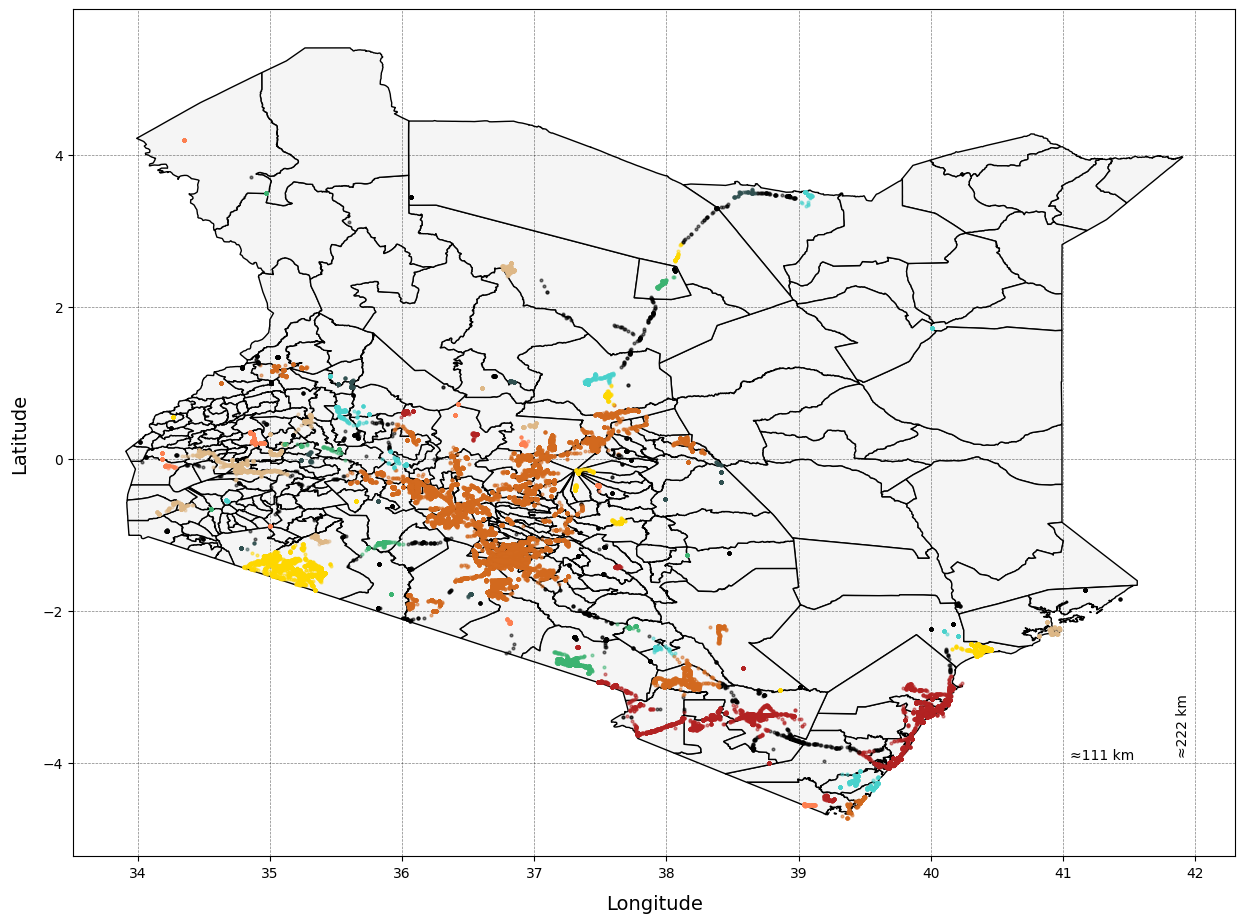

In [10]:
# initialize our model
db = DBSCAN(eps=0.1, min_samples=50).fit(coords)
location_data['cluster'] = db.labels_

# plot the map
kenya_boundaries = gpd.read_file(kenya_filepath)
fig, ax = plt.subplots(figsize=(15, 11))
kenya_boundaries.plot(ax=ax, color="whitesmoke", edgecolor="black")
ax.set_aspect("auto")
ax.grid(color="black", linestyle="--", linewidth=0.5, alpha=0.5)


# plot the clusters
colors = ['firebrick', 'coral', 'chocolate', 'burlywood', 'gold', 'mediumseagreen', 'mediumturquoise', 'darkslategrey']

for idx, row in location_data.iterrows():
    cluster_label = row['cluster']
    color = colors[int(cluster_label) % len(colors)] if cluster_label != -1 else 'black'
    ax.plot(row['decimalLongitude'], row['decimalLatitude'], 'o', markersize=2, color=color, alpha=0.5)

ax.set_xlabel("Longitude", fontsize=14, labelpad=10)
ax.set_ylabel("Latitude", fontsize=14, labelpad=10)

scalebar_text_x = "≈111 km"
scalebar_text_y = "≈222 km"
ax.text(
    0.885, 0.115, scalebar_text_x, 
    transform=ax.transAxes, ha="center", 
    fontsize=10, color="black"
)
ax.text(
    0.955, 0.12, scalebar_text_y, 
    transform=ax.transAxes, ha="center", rotation=90,
    fontsize=10, color="black"
)
fig.savefig(plots_dir + "clustering-map.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

### Comment
We can see on the map that the area with the significantly higher concentration of sightings is the area represented by the orange cluster, around the mid-south part of Kenya.

# 4. Species Richness Map

## General Information & Ideas:

1. In a species richness map, we count the number of unique species that occur at a location, not the number of individual instances of those species.
2. Ordinary Kriging is a geostatistical interpolation method that estimates unknown values at specific locations based on spatial autocorrelation. The idea that nearby points are more similar to each other than distant points.
3. In a species richness map, simpler interpolation methods like linear, cubic, or nearest-neighbor interpolation should be sufficient. Kriging is more appropriate when we have strong spatial autocorrelation in the data, which should not be the case for species richness. We will thus use cubic interpolation (cubic for a more smoother interpolation map).

## Algorithm for creating species richness map:

1. Load species data and geographical area data.
2. Create a grid of cells across the geographic area based on latitude and longitude.
3. Initialize a dictionary to store species sets and counts for each grid cell.
4. Count the number of unique species within each grid cell: iterate through the species data and update the species set for each corresponding grid cell based on the row's latitude and longitude.
5. Interpolate the species richness across the latitude and longitude grid.
6. Mask the data outside of Kenya's boundary with *NaN*.
7. Overlay the species richness map on the geographical area map.

In [11]:
def speciesRichnessMap(
        data, kenya, 
        species_n_cells=21, grid_n_cells=100,
        load_grid=False, apply_gaussian=True,
        grid_x_path=f"{grids_dir}grid_x.npy", grid_y_path=f"{grids_dir}grid_y.npy", grid_z_path=f"{grids_dir}grid_z.npy"):
    """
    Creates a bird species richness heatmap over Kenya using the following algorithm:
        1. Creates a grid spanning Kenya's bounding box.
        2. Aggregates unique species counts within each grid cell.
        3. Interpolates species richness across the grid 
        4. Masks values outside Kenya's boundary and applies Gaussian smoothing.
        5. Plots the species richness heatmap overlaid on Kenya's map
    
    Parameters:
        - data (pd.DataFrame): Contains 'decimalLatitude', 'decimalLongitude', and 'species' columns.
        - kenya (GeoDataFrame): Contains Kenya's boundary geometry.
        - load_grid (bool): If True, loads grids from specified paths, otherwise computes them.
        - apply_gaussian (bool): Whether to apply gaussian filter on grid_z data or not.
        - grid_x_path, grid_y_path, grid_z_path (str): paths to save/load the grid data files.
    """
    if load_grid:
        # load precomputed grids from file
        grid_x = np.load(grid_x_path)
        grid_y = np.load(grid_y_path)
        grid_z = np.load(grid_z_path)
    else:
        # step 1: define grid bounds based on Kenya's boundary (take min/max over given longitude/latitude observations and actual kenya boundaries)
        kenya_min_x, kenya_min_y, kenya_max_x, kenya_max_y = kenya.total_bounds
        species_grid_x = np.linspace(min(data["decimalLongitude"].min(), kenya_min_x), max(data["decimalLongitude"].max(), kenya_max_x), species_n_cells)
        species_grid_y = np.linspace(min(data["decimalLatitude"].min(), kenya_min_y), max(data["decimalLatitude"].max(), kenya_max_y), species_n_cells)
        # step 2.1: initialize dictionary to store species sets and unique species count for each grid cell
        grid_dict = {
            (i, j): {
                "species": set(), 
                "unique": 0, 
                "long_lat": (species_grid_x[i], species_grid_y[j])
            } for i in range(species_n_cells) for j in range(species_n_cells)
        }
        
        # step 2.2: count unique species within each grid cell by iterating through species data
        for index, row in data.iterrows():
            # determine which cell the current species belongs to based on its coordinates
            longitude_idx = np.digitize(row["decimalLongitude"], species_grid_x) - 1
            latitude_idx = np.digitize(row["decimalLatitude"], species_grid_y) - 1
            # update the species set and count for the cell
            species = row["species"]
            cell = grid_dict[(longitude_idx, latitude_idx)]
            if species not in cell["species"]:
                cell["species"].add(species)
                cell["unique"] += 1

        # step 3.1: convert grid dictionary to points and values arrays for interpolation
        points = []
        values = []
        for (i, j), value in grid_dict.items():
            points.append(value["long_lat"]) # longitude, latitude coordinates
            values.append(value["unique"]) # unique species count in cell
        points = np.array(points)
        values = np.array(values)
        
        # step 3.2: interpolate species richness values across the grid
        longitudes, latitudes = points[:, 0], points[:, 1]
        grid_x, grid_y = np.meshgrid(
            np.linspace(min(longitudes), max(longitudes), grid_n_cells),
            np.linspace(min(latitudes), max(latitudes), grid_n_cells)
        )
        grid_z = griddata((longitudes, latitudes), values, (grid_x, grid_y), method="cubic")
        
        # step 4.1: convert heatmap coordinates to GeoDataFrame for masking
        heatmap_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(grid_x.flatten(), grid_y.flatten()))
        heatmap_points.set_crs(epsg=4326, inplace=True)
        
        # step 4.2: mask grid_z to keep only values within Kenya's boundary
        within_kenya = heatmap_points.within(kenya.unary_union)
        grid_z = np.where(within_kenya.values.reshape(grid_x.shape), grid_z, np.nan)

        # save computed grids to files for future use
        np.save(grid_x_path, grid_x)
        np.save(grid_y_path, grid_y)
        np.save(grid_z_path, grid_z)
    
    # apply Gaussian filter to smooth the heatmap
    if apply_gaussian:
        grid_z = gaussian_filter(grid_z, sigma=1)

    # step 5: plot the heatmap overlayed on Kenya's map
    fig = plt.figure(figsize=(15, 11))
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.2)  # main plot takes 20x space, color bar takes 1x space

    # main plot area
    ax = fig.add_subplot(gs[0])
    kenya.plot(ax=ax, color="white", edgecolor="black", linewidth=1)
    ax.set_aspect("auto")
    ax.grid(color="black", linestyle="--", linewidth=0.5, alpha=0.5)

    cmap = plt.cm.get_cmap("jet")
    colors = cmap(np.linspace(0, 1, 256))
    # darken the first 50 color values for a more distinct heatmap
    darkening_factors = np.linspace(0.1, 1, 75)
    colors[:75, :] *= darkening_factors[:, np.newaxis]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_jet", colors)

    c = ax.pcolormesh(grid_x, grid_y, grid_z, cmap=custom_cmap, shading="auto", alpha=0.8)
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)

    # color bar area
    cax = fig.add_subplot(gs[1])
    colorbar = fig.colorbar(c, cax=cax)
    colorbar.set_label("Species Count", fontsize=14, labelpad=-85)
    
    # add max species count text
    max_species = np.nanmax(grid_z)
    ax.text(
        0.785, 0.98,
        f"Max Species Count: {int(max_species)}",
        transform=ax.transAxes,
        fontsize=12, color="black", verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5)
    )
    # add scale bar text
    scalebar_text_x = "≈111 km"
    scalebar_text_y = "≈222 km"
    ax.text(
        0.925, 0.08, scalebar_text_x, 
        transform=ax.transAxes, ha="center", 
        fontsize=10, color="black"
    )
    ax.text(
        0.99, 0.08, scalebar_text_y, 
        transform=ax.transAxes, ha="center", rotation=90,
        fontsize=10, color="black"
    )

    # save the figure
    fig.savefig(plots_dir + "species_richness_kenya.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()

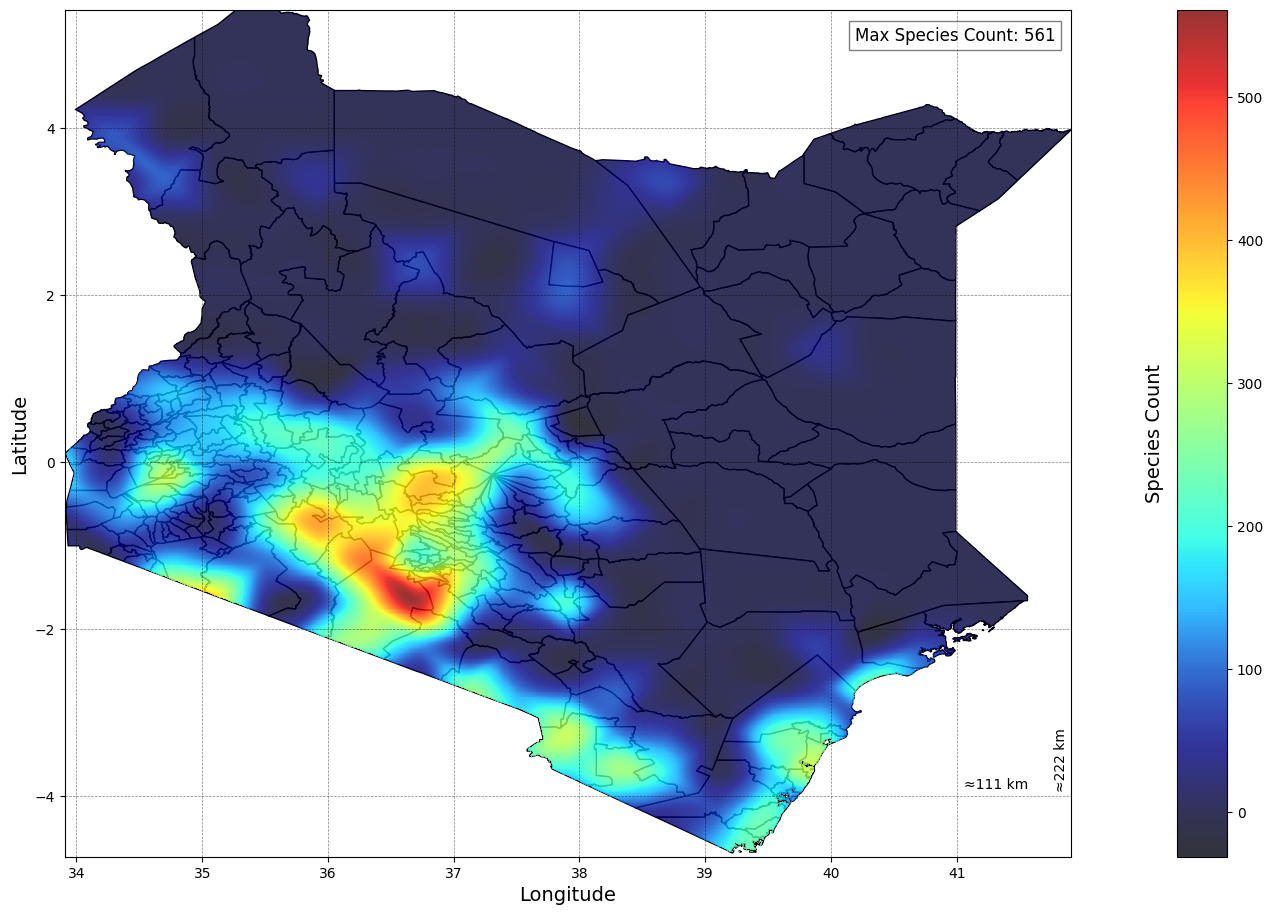

In [12]:
# increase grid_n_cells for a finer heatmap
# provided grid_x.npy, grid_y.npy and grid_z_masked.npy were computer with grid_n_cells=1000
# note that higher grid_n_cells, higher the runtime is
speciesRichnessMap(data=data, kenya=kenya, load_grid=True, apply_gaussian=False)